## Notebook Purpose

Initial experiments with ConvDecoder, based upon the original notebook `ConvDecoder_vs_DIP_vs_DD_multicoil.ipynb`.

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from utils.transform import np_to_tt, np_to_var, apply_mask, ifft_2d, fft_2d, \
                            reshape_complex_channels_to_sep_dimn, \
                            reshape_complex_channels_to_be_adj, \
                            split_complex_vals, combine_complex_channels, \
                            crop_center, root_sum_of_squares, recon_ksp_to_img
from utils.helpers import num_params, load_h5, get_masks
from include.decoder_conv import convdecoder
from include.mri_helpers import get_scale_factor
from include.fit import fit
from utils.evaluate import calc_metrics

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(1)
else:
    dtype = torch.FloatTensor

In [2]:
def init_convdecoder(slice_ksp, mask):
    ''' parameters: 
                slice_ksp: original, unmasked k-space measurements
                mask: mask used to downsample original k-space
        return:
                net: initialized convdecoder
                net_input: random, scaled input seed 
                ksp_masked: masked measurements to fit
                img_masked: masked image, i.e. ifft(ksp_masked) '''

    in_size = [8,4]
    out_size = slice_ksp.shape[1:] # shape of (x,y) image slice, e.g. (640, 368)
    out_depth = slice_ksp.shape[0]*2 # 2*n_c, i.e. 2*15=30 if multi-coil
    num_layers = 8
    strides = [1]*(num_layers-1)
    num_channels = 160
    kernel_size = 3

    net = convdecoder(in_size, out_size, out_depth, num_layers, \
                      strides, num_channels).type(dtype)
#     print('# parameters of ConvDecoder:',num_params(net))
    
    # generate network input
    # fix scaling b/w original image and network output
    scale_factor, net_input = get_scale_factor(net,
                                       num_channels,
                                       in_size,
                                       slice_ksp)
    slice_ksp = slice_ksp * scale_factor # original fit_untrained() f'n returns this

    # mask the kspace
    ksp_masked = apply_mask(np_to_tt(slice_ksp), mask=mask)
    ksp_masked = np_to_var(ksp_masked.data.cpu().numpy()).type(dtype)

    # perform ifft of masked kspace
    img_masked = ifft_2d(ksp_masked[0]).cpu().numpy()
    img_masked = reshape_complex_channels_to_be_adj(img_masked)
    img_masked = np_to_var(img_masked).type(dtype)
        
    return net, net_input, ksp_masked, img_masked, slice_ksp

def data_consistency(img_out, slice_ksp, mask1d):
    ''' perform data-consistency step so no 
        parameters:
                img_out: network output image, shape torch.Size([30, x, y])
                slice_ksp: original k-space measurements 
        returns:
                img_dc: data-consistent output image
                img_est: output image without data consistency '''
    
    img_out = reshape_complex_channels_to_sep_dimn(img_out)

    # now get F*G(\hat{C}), i.e. estimated recon in k-space
    ksp_est = fft_2d(img_out) # ([15, 640, 368, 2])
    ksp_orig = np_to_tt(split_complex_vals(slice_ksp)) # ([15, 640, 368, 2]); slice_ksp (15,640,368) complex

    # replace estimated coeffs in k-space by original coeffs if it has been sampled
    mask1d = torch.from_numpy(np.array(mask1d, dtype=np.uint8)) # shape: torch.Size([368]) w 41 non-zero elements
    ksp_dc = ksp_est.clone().detach().cpu()
    ksp_dc[:,:,mask1d==1,:] = ksp_orig[:,:,mask1d==1,:]

    img_dc = recon_ksp_to_img(ksp_dc)
    img_est = recon_ksp_to_img(ksp_est.detach().cpu())
    
    return img_dc, img_est

In [3]:
## UNCOMMENT for half precision and INJECT before fitting network
# net = net.half()
# ksp_masked = ksp_masked.half()
# img_masked = img_masked.half()
# mask = mask.half()
# dtype=torch.cuda.HalfTensor

### Run expmts

In [10]:
file_id_list = ['1000267', '1000292', '1000254', '1000178']   
    
img_dc_list, img_est_list, img_gt_list, metrics_dc = [], [], [], []

NUM_ITER_LIST = [1, 1000]

for idx, file_id in enumerate(file_id_list):  
    
    # load full mri measurements
    f, slice_ksp = load_h5(file_id)
    if f['kspace'].shape[3] == 320:
        continue
    print('file_id: {}'.format(file_id))

    # load mask, M
    mask, mask2d, mask1d = get_masks(f, slice_ksp)
    
    # make torch versions for data consistency step in fit()
    mask1d_ = torch.from_numpy(np.array(mask1d, dtype=np.uint8)) 
    ksp_orig = np_to_tt(split_complex_vals(slice_ksp)) # ([15, 640, 368, 2]); slice_ksp (15,640,368) complex
    
    for NUM_ITER in NUM_ITER_LIST:
    
        net, net_input, ksp_masked, img_masked, slice_ksp = \
                init_convdecoder(slice_ksp, mask)
        
        net, mse_wrt_ksp, mse_wrt_img = fit(
            ksp_masked=ksp_masked, img_masked=img_masked,
            net=net, net_input=net_input, mask2d=mask2d,
            mask1d=mask1d_, ksp_orig=ksp_orig,
            img_ls=None, num_iter=NUM_ITER, dtype=dtype)

        img_out = net(net_input.type(dtype))[0] # estimate image \hat{x} = G(\hat{C})

        img_dc, img_est = data_consistency(img_out, slice_ksp, mask1d)
        img_gt = recon_ksp_to_img(slice_ksp) # must do this after slice_ksp is scaled

        # save images, metrics
        img_dc_list.append(img_dc)
        img_est_list.append(img_est)
        img_gt_list.append(img_gt) # could do this once per loop
#         metrics_dc.append(calc_metrics(img_dc, img_gt))

file_id: 1000267
under-sampling factor: 4.21
file_id: 1000292
under-sampling factor: 4.28
file_id: 1000254
under-sampling factor: 4.28
file_id: 1000178
under-sampling factor: 4.09


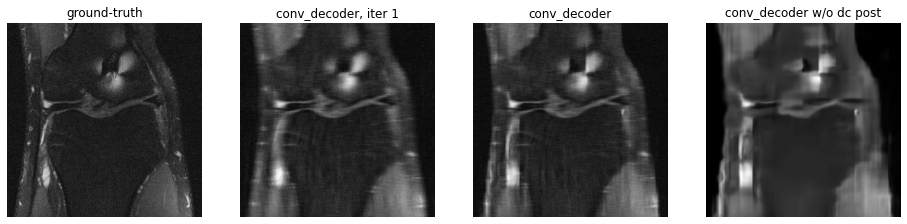

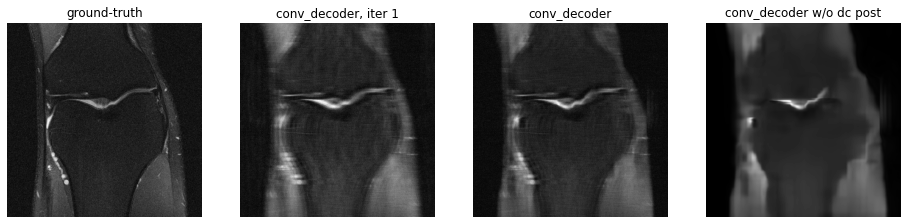

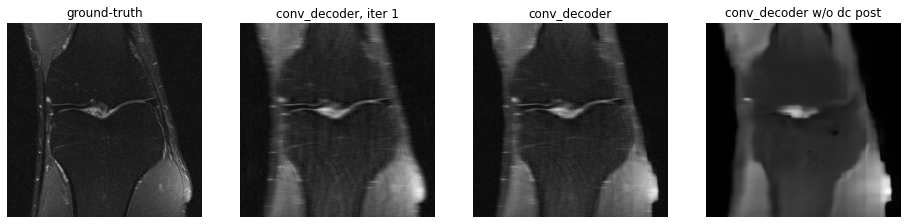

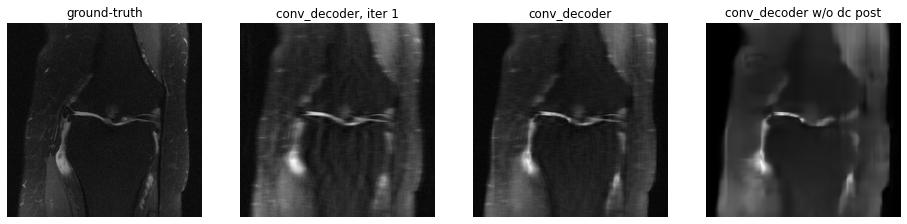

In [11]:
for i in np.arange(0, 2*len(file_id_list), 2):
    
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(141)
    ax1.imshow(img_gt_list[i], cmap='gray')
    ax1.set_title('ground-truth')
    ax1.axis('off')

    ax2 = fig.add_subplot(142)
    ax2.imshow(img_dc_list[i], cmap='gray')
    ax2.set_title('conv_decoder, iter {}'.format(np.array(NUM_ITER_LIST).min()))
    ax2.axis('off')

    ax3 = fig.add_subplot(143)
    ax3.imshow(img_dc_list[i+1], cmap='gray')
    ax3.set_title('conv_decoder')
    ax3.axis('off')
    
    ax4 = fig.add_subplot(144)
    ax4.imshow(img_est_list[i+1], cmap='gray')
    ax4.set_title('conv_decoder w/o dc post')
    ax4.axis('off')
    
#     plt.savefig('png_out/sample{}.png'.format(i//2))
    plt.show()

In [ ]:
img_gt_shifted = img_gt * (img_dc.mean() / img_gt.mean())

# est is output image without data consistency step
plt.hist(img_est.flatten(), bins=100, alpha=0.5, label='est')
plt.hist(img_dc.flatten(), bins=100, alpha=0.5, label='dc')
plt.hist(img_gt.flatten(), bins=100, alpha=0.5, label='gt')
plt.legend()
plt.show()